In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [58]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [59]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Cancer',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2357 files belonging to 9 classes.


In [60]:
class_names = dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [61]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [62]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [63]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 5 1 3 0 0 8 7 4 4 5 2 1 3 1 5 3 1 7 5 5 1 2 3 8 1 1 5 6 3 5 6]


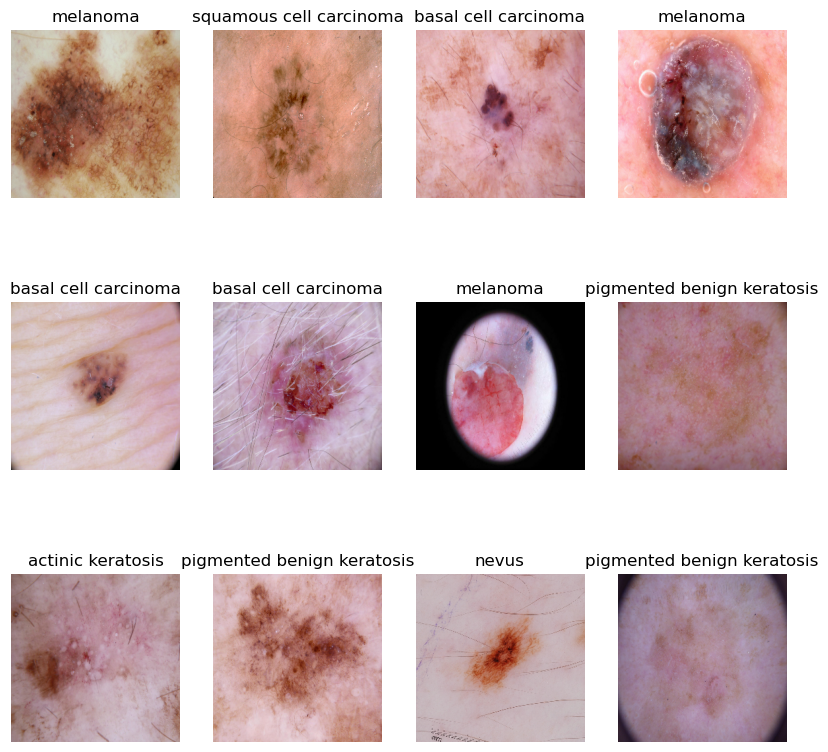

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [65]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [66]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [67]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
])

In [68]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                               include_top=False, weights='imagenet')
base_model.trainable = False

C:\Users\husni\AppData\Local\Temp\ipykernel_16584\2275866691.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),


In [69]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=200, validation_data=val_ds)

Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 474ms/step - accuracy: 0.2945 - loss: 2.0054 - val_accuracy: 0.4509 - val_loss: 1.6143
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 493ms/step - accuracy: 0.4087 - loss: 1.6527 - val_accuracy: 0.4286 - val_loss: 1.5563
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 433ms/step - accuracy: 0.4427 - loss: 1.6049 - val_accuracy: 0.4777 - val_loss: 1.4854
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.4963 - loss: 1.4275 - val_accuracy: 0.4911 - val_loss: 1.4131
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.4890 - loss: 1.4169 - val_accuracy: 0.5134 - val_loss: 1.3793
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.5342 - loss: 1.3530 - val_accuracy: 0.5268 - val_loss: 1.3472
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.5199 - loss: 1.3267 - val_accuracy: 0.5134 - val_loss: 1.3753
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.5363 - loss: 1.3241 - 

In [75]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.8981 - loss: 0.4930


[0.5522655248641968, 0.890625]

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label:  pigmented benign keratosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Predicted Label: pigmented benign keratosis


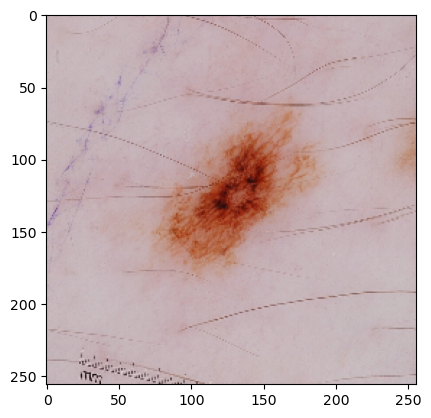

In [77]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[10].numpy().astype('uint8')
    first_label = labels_batch[10].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[10])])

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


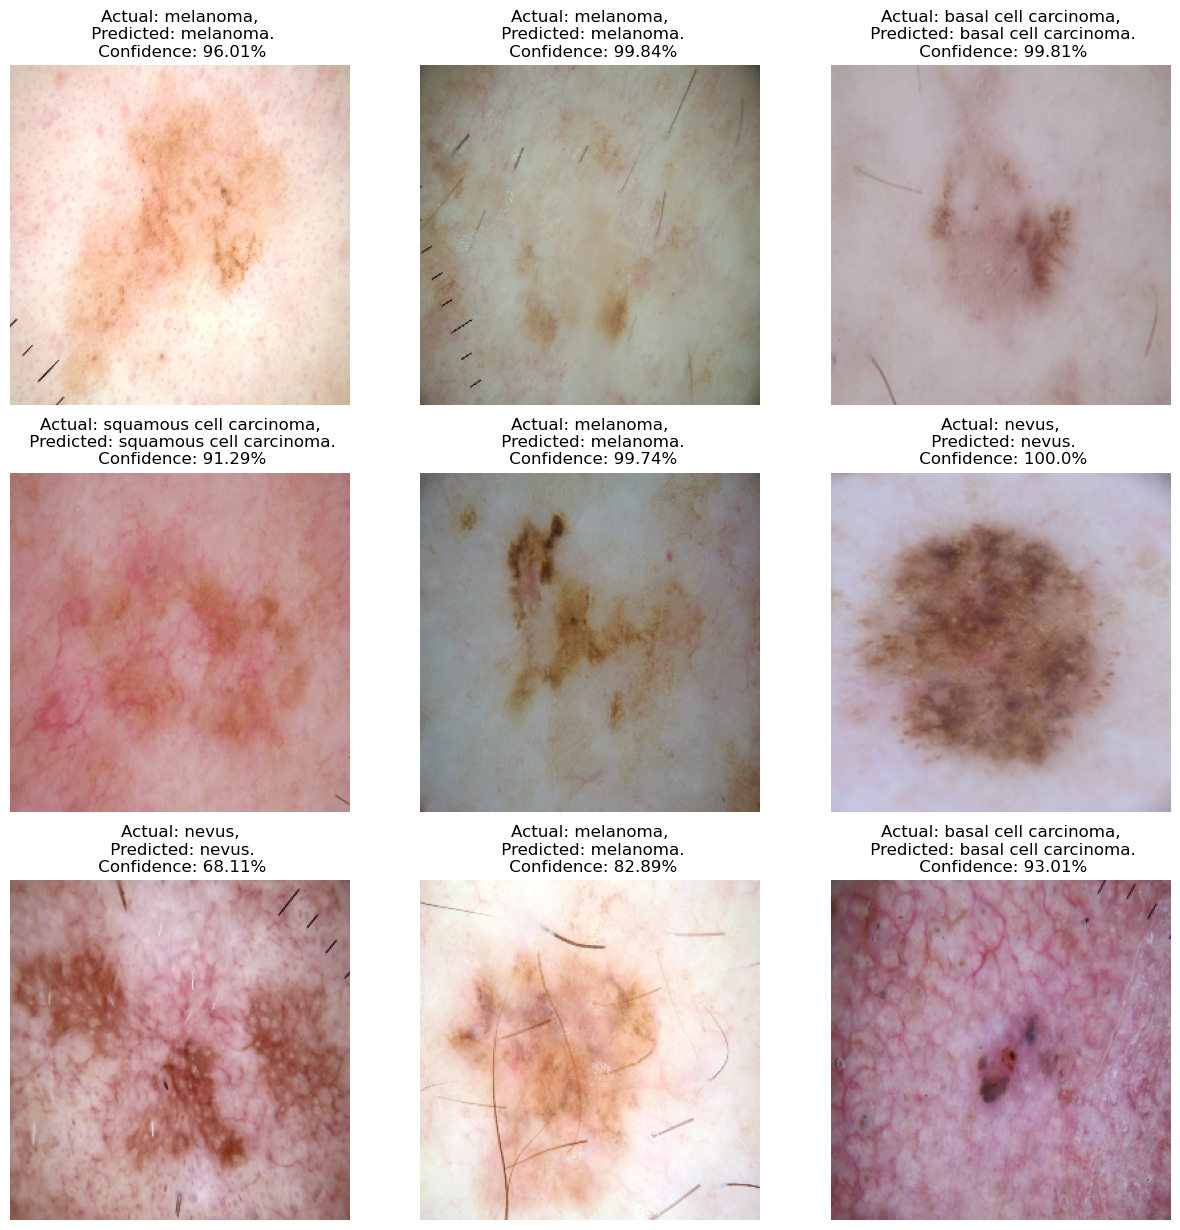

In [79]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [82]:
import os
current_dir = os.getcwd()
model_version = max([int(i) for i in os.listdir(current_dir) if i.isdigit()] + [0]) + 1
model.save(f"{current_dir}/{model_version}.keras")